# Mnist Exploration

This is a simple notebook intended to practice using pytorch to classify mnist images.

This is going to be taking what I might call a "top-down" approach, progressively implementing more things from scratch as I go down, to further deepen my understanding of both pytorch and neural network algorithms.

For a first blush, we'll try simple logistic regression/softmax to get a feel for baseline performance.  Then we'll proceed to using transfer learning using a variety of pretrained models.  After that, we'll try various architectures of deep neural nets, but as we proceed further and further, we'll rely more on code "from-scratch" over pre-existing PyTorch functionality.

Note that the "from-scratch" code will be written in different directories so that I can share them with other notebooks -- thus those will not be listed here.

Deliberately, this will use only pytorch: no scikit-learn.

In [1]:
#PyTorch

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent / "src"))

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

import torchmetrics

import numpy as np
import matplotlib.pyplot as plt

from pytorch_util.simple_trainer import SimpleTrainer

from IPython.display import clear_output

np.random.seed(120418)

In [2]:
# Fetch the data from the web if needed.

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Let's show a few sample images from our dataset.

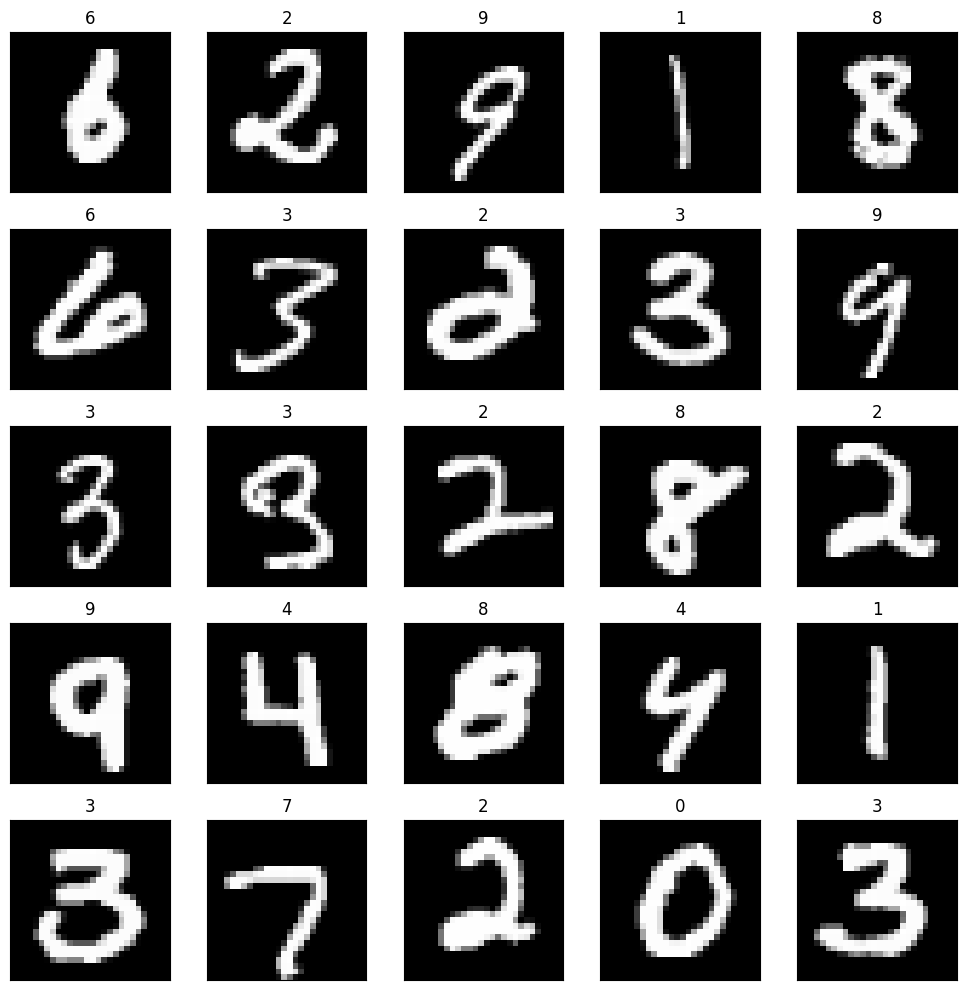

In [3]:

num_images = 25

train_indices = np.random.choice(range(len(train_dataset)), size=25, replace=False)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()

for axis_num, train_index in enumerate(train_indices):
    ax = axes[axis_num]
    ax.set_xticks([])
    ax.set_yticks([])
    img = train_dataset[train_index][0]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(train_dataset[train_index][1])

plt.tight_layout()
plt.show()

At least in this random run, we see largely labeled images, which have correct values.  Nothing seems overly ambiguous, though the "9" at the end of the 2nd row and the "4" in the 4th position of the 4th row look maybe a bit too similar for comfort, which opens up the possibility of ambiguities in the remainder of the training set.

For a "lower-level baseline", let's try a simple logistic regression on the training set.  We won't bother with cross-validation for such a simple model.

## Training with Logistic Regression

Epoch 16: loss: 0.22522404069900512, metric: 0.937833309173584
Epoch 17: loss: 0.22362536574204764, metric: 0.9387833476066589
Epoch 18: loss: 0.22355877390702567, metric: 0.9391166567802429
Epoch 19: loss: 0.22321060639222462, metric: 0.9389833211898804
Epoch 20: loss: 0.22292005797227224, metric: 0.938966691493988


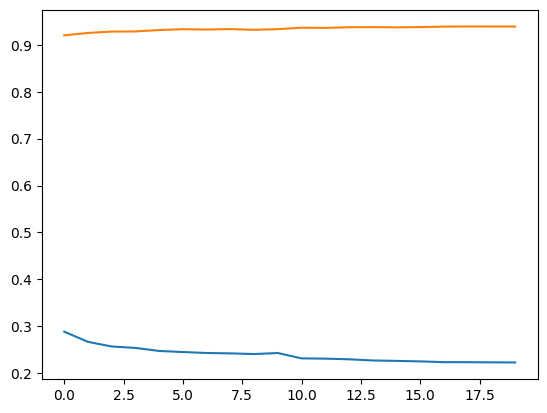

In [12]:
image_size = train_dataset[0][0].flatten().shape[0]
num_targets = 10

train_batch_size = 256
batch_increase_frequency = 4

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
model = nn.Sequential(
    nn.Linear(image_size, num_targets),
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_targets)

criterion = nn.CrossEntropyLoss()
start_learning_rate = 1e-2
min_learning_rate = 1e-3
patience = 5

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 20
losses = []
accuracies = []

best_loss = float('inf')
best_model_state = None
counter = 0

last_messages = []
window = 5

scheduler = CosineAnnealingLR(
    optimizer, T_max=epochs, eta_min=1e-6
)

result = SimpleTrainer.train(
    model,
    train_dataloader,
    optimizer,
    criterion,
    epochs,
    metric,
    per_epoch_callbacks=[ lambda : scheduler.step() ],
    print_progress=True
)

plt.plot(result["losses"])
plt.plot(result["metrics"])
plt.show()

Let's now evaluate this model on the test set

In [ ]:
print(losses)

# test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

# metric.reset()
# test_loss = 0.0
# with torch.no_grad():
#     for images, labels in test_dataloader:
#         images = images.view(images.shape[0], -1)
#         preds = model(images)
#         test_loss = criterion(preds, labels).item()
#         metric.update(preds, labels)

# print(f"Loss: {test_loss}, accuracy: {metric.compute()}")


So with this run, we're seeing 92.3% accuracy on the test set.  This is in line with normal expectations of logistic regression on this dataset.

Let's see some errors from the training set.


In [ ]:
num_images = 25

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

preds = None
labels = None
images = None

with torch.no_grad():
    for images, labels2 in train_dataloader:
        images = images.view(images.shape[0], -1)
        preds = model(images)
        labels = labels2


pred_classes = preds.argmax(dim=1)
misclassified_indices = (pred_classes != labels).nonzero(as_tuple=True)[0]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flatten()

for i in range(min(25, len(misclassified_indices))):
    ax = axes[i]
    image_index = misclassified_indices[i]
    ax.set(xticks=[], yticks=[])
    img = images[image_index].reshape(1, 28, 28)
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Predicted: {pred_classes[image_index]}, Actual: {labels[image_index]}")

plt.tight_layout()
plt.show()

Some of these errors are understandable: the 4th element in the 3rd row and the 1st element in the 4th row are plausibly a bit ambiguous.  But most of these are rather head-scratching.  In any case, in the interests of exploration, let's move on to tack 2: deep learning, where now we'll focus more on proper technique with cross-validation, etc.

##  Deep Learning

We'll try some deep learning architectures.